In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.1.1'

In [4]:
DATA_DIR_PATH = os.path.join('..', '..', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [5]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
df_train.head(3)

199


,ncode,title,category,bookmark_cat,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,...,wc_その他-間投,wc_名詞-固有名詞-人名-名,wc_助動詞,wc_助詞-接続助詞,wc_名詞-代名詞-一般,wc_副詞-一般,wc_名詞-接続詞的,wc_名詞-固有名詞-組織,wc_記号-句点,rating
0,n4366gd,雷帝の軌跡 ～俺だけ使える【雷魔術】で最強の魔術師を目指します～,ハイファンタジー〔ファンタジー〕,1,1.586338e+09,1.593468e+09,92340,3840,28950,992220,...,0,30,4680,2250,900,570,0,0,1830,3.0
1,n7336gg,星斬りの剣士,ハイファンタジー〔ファンタジー〕,1,1.590714e+09,1.593338e+09,77880,4140,4950,863400,...,0,90,4320,1620,1590,390,0,60,2280,4.0
2,n9677fw,落ちこぼれ国を出る〜実は世界で４人目の付与術師だった件について〜,ハイファンタジー〔ファンタジー〕,1,1.575176e+09,1.593429e+09,59880,3090,10230,628470,...,0,240,2490,1260,450,360,30,0,930,3.0


In [25]:
# df_test = laod_data('ranking_test_data.csv')
# print(len(df_test))
# df_test.head(3)

In [58]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])


def data_preprocess(df):
  new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

  new_df['category'] = cat_le.transform(new_df['category'])

  kw_columns = [col for col in new_df.columns if col.find('kw_') != -1]
  new_df = new_df.drop(kw_columns, axis=1)

  wc_columns = [col for col in new_df.columns if col.find('wc_') != -1]
  new_df = new_df.drop(wc_columns, axis=1)

  return new_df

In [59]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,avg_char_count,avg_new_line_count,avg_talk_char_count,avg_word_count,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,992220,3078.0,128.0,965.0,33074.0,3.0
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,863400,2596.0,138.0,165.0,28780.0,4.0
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,628470,1996.0,103.0,341.0,20949.0,3.0


In [60]:
X = df_train2.drop(['rating'], axis=1).values
y = df_train2['rating'].values
print(X.shape, y.shape)

(199, 11) (199,)


In [61]:
df_train2.keys()

Index(['category', 'created_at', 'updated_at', 'sum_char_count',
       'sum_new_line_count', 'sum_talk_char_count', 'sum_word_count',
       'avg_char_count', 'avg_new_line_count', 'avg_talk_char_count',
       'avg_word_count', 'rating'],
      dtype='object')

In [62]:
print(y)

[3.   4.   3.   4.   3.   3.   3.   4.   5.   2.   4.   4.   3.   3.
 5.   4.   4.   4.   3.   2.5  2.   3.   2.   4.   4.   4.   3.5  3.
 2.   2.   4.   3.   4.   2.   3.   2.   3.5  2.   2.   3.   3.5  3.5
 3.5  1.   3.   4.5  7.5  6.   1.5  6.   6.   3.   6.   4.5  4.5  3.
 4.5  4.5  4.5  5.25 1.5  1.5  4.5  4.5  5.25 4.5  6.   1.5  4.5  4.5
 5.25 4.5  4.5  7.5  4.5  4.5  5.25 6.   5.25 6.75 6.   4.5  4.5  6.
 5.25 4.5  5.25 6.75 6.   5.25 1.   1.5  0.5  1.75 1.5  1.   1.5  1.5
 1.   1.5  1.5  1.   0.5  1.   1.5  1.5  1.5  1.   1.   1.   1.5  1.5
 1.   1.5  1.   1.   1.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  1.   0.5
 0.5  0.5  0.5  1.   1.5  1.   1.5  1.5  1.   1.   0.5  1.5  1.   1.
 1.5  1.5  1.5  1.   0.5  0.5  1.5  1.75 1.5  1.5  1.   1.   1.5  1.5
 1.5  1.   0.5  0.5  1.5  1.5  1.5  1.5  1.75 1.   1.   1.5  1.5  1.5
 1.5  1.5  1.5  1.5  1.   1.5  0.5  1.5  1.75 1.5  1.75 1.5  1.5  1.5
 1.5  1.5  1.   1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.   1.5
 1.5  1.   1.5 ]


In [63]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(
X_train, X_val, y_train, y_val = train_test_split(
    #X, y, test_size=0.3, shuffle=True, random_state=1, stratify=y)
    X, y, test_size=0.3, shuffle=True, random_state=1)

In [64]:
print(X_train.shape, y_train.shape)

(139, 11) (139,)


In [65]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [66]:
print(dtrain.feature_names)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']


In [67]:
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=20,
                evals=evals,
                evals_result=evals_result)

[22:13:09] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.16875	eval-rmse:1.94481
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:1.78508	eval-rmse:1.65090
[2]	train-rmse:1.40149	eval-rmse:1.59658
[3]	train-rmse:1.17607	eval-rmse:1.52296
[4]	train-rmse:1.00594	eval-rmse:1.50894
[5]	train-rmse:0.82590	eval-rmse:1.49901
[6]	train-rmse:0.70681	eval-rmse:1.51065
[7]	train-rmse:0.62564	eval-rmse:1.53123
[8]	train-rmse:0.53830	eval-rmse:1.53914
[9]	train-rmse:0.48543	eval-rmse:1.55377
[10]	train-rmse:0.46219	eval-rmse:1.55478
[11]	train-rmse:0.40642	eval-rmse:1.56254
[12]	train-rmse:0.36596	eval-rmse:1.56237
[13]	train-rmse:0.34671	eval-rmse:1.56527
[14]	train-rmse:0.31414	eval-rmse:1.57094
[15]	train-rmse:0.29483	eval-rmse:1.57170
[16]	train-rmse:0.26315	eval-rmse:1.56873
[17]

In [68]:
import math
from sklearn.metrics import mean_squared_error

y_pred = bst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 1.5884454369508634


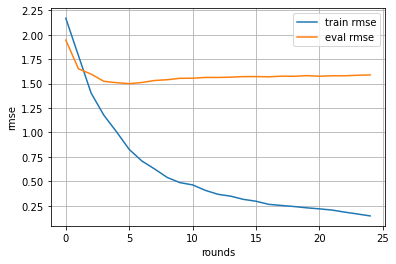

In [69]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

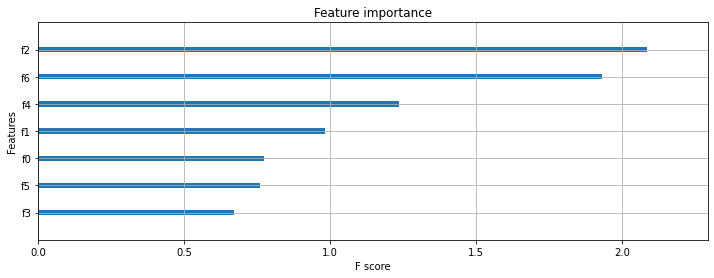

In [70]:
_, ax = plt.subplots(figsize=(12, 4))

xgb.plot_importance(bst,ax=ax,
                    importance_type='gain',
                    show_values=False)

plt.show()

{'f0': 'category', 'f1': 'created_at', 'f2': 'updated_at', 'f3': 'sum_char_count', 'f4': 'sum_new_line_count', 'f5': 'sum_talk_char_count', 'f6': 'sum_word_count', 'f7': 'avg_char_count', 'f8': 'avg_new_line_count', 'f9': 'avg_talk_char_count', 'f10': 'avg_word_count', 'f11': 'rating'}
{'updated_at': 94, 'created_at': 182, 'category': 55, 'sum_word_count': 39, 'sum_new_line_count': 76, 'sum_char_count': 101, 'sum_talk_char_count': 70}


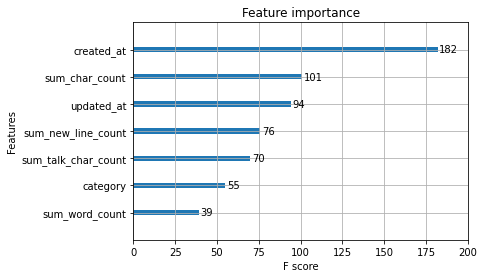

In [86]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(df_train2.columns)}
print(mapper)

mapped = {mapper[k]: v for k, v in bst.get_fscore().items()}
print(mapped)

xgb.plot_importance(mapped)

In [71]:
#bst.get_fscore()
#sorted(bst.get_fscore().items(), key=lambda x:x[1])
sorted_fscore = sorted(bst.get_fscore().items(), key=lambda x:x[1])
sorted_fscore.reverse()
sorted_fscore

[('f1', 182),
 ('f3', 101),
 ('f2', 94),
 ('f4', 76),
 ('f5', 70),
 ('f0', 55),
 ('f6', 39)]

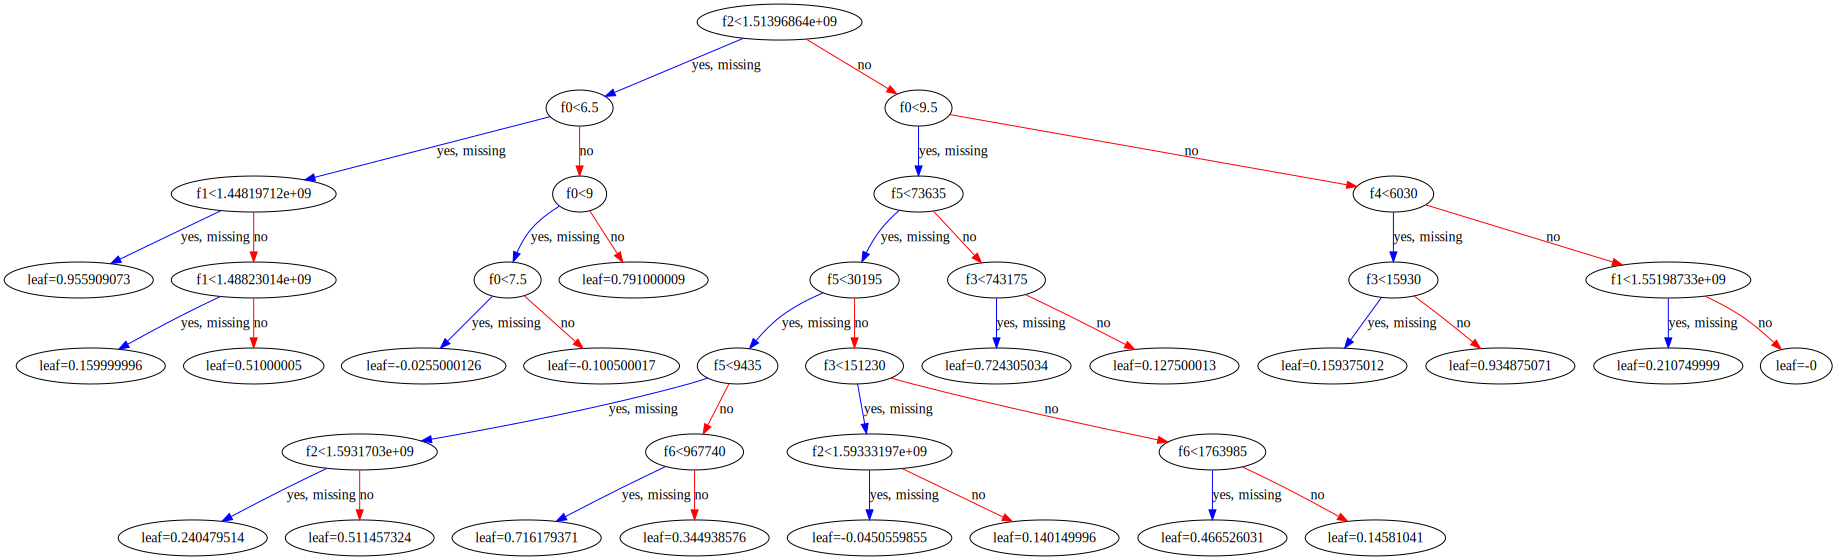

In [72]:
xgb.to_graphviz(bst, num_trees=1)

In [73]:
y_pred.shape

(60,)

In [74]:
df_test = laod_data('ranking_test_data.csv')
print(len(df_test))
df_test.head(3)

65


,ncode,title,category,bookmark_cat,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,...,wc_動詞-非自立,wc_助詞-並立助詞,wc_接頭詞-数接続,wc_名詞-接続詞的,wc_形容詞-自立,wc_名詞-固有名詞-人名-一般,wc_記号-括弧開,wc_名詞-固有名詞-人名-名,wc_名詞-接尾-形容動詞語幹,rating
0,n8642gc,聖貨を集めて、ぶん回せ！,ハイファンタジー〔ファンタジー〕,-1,1.585469e+09,1.593763e+09,37740,2310,0,383130,...,30,240,0,0,270,30,480,60,0,-1
1,n8693gg,十年目、帰還を諦めた転移者はいまさら主人公になる,ハイファンタジー〔ファンタジー〕,-1,1.591009e+09,1.593774e+09,144330,5760,44100,1561170,...,1680,60,0,0,1710,0,1800,270,60,-1
2,n4452ge,俺だけレベルが上がる世界で悪徳領主になっていた,ハイファンタジー〔ファンタジー〕,-1,1.587737e+09,1.593006e+09,156720,6210,13290,1636680,...,1890,180,0,0,930,60,810,0,60,-1


In [75]:
df_test2 = data_preprocess(df_test)
df_test2.head(3)

,category,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,avg_char_count,avg_new_line_count,avg_talk_char_count,avg_word_count,rating
0,6,1.585469e+09,1.593763e+09,37740,2310,0,383130,1258.0,77.0,0.0,12771.0,-1
1,6,1.591009e+09,1.593774e+09,144330,5760,44100,1561170,4811.0,192.0,1470.0,52039.0,-1
2,6,1.587737e+09,1.593006e+09,156720,6210,13290,1636680,5224.0,207.0,443.0,54556.0,-1


In [76]:
X = df_test2.drop(['rating'], axis=1).values
y = df_test2['rating'].values
print(X.shape)

#dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X, label=y)
print(dtest)

(65, 11)


In [77]:
y_pred = bst.predict(dtest)
y_pred

array([2.9747853 , 2.1415815 , 3.049545  , 2.648631  , 2.6607714 ,
       2.411335  , 2.3464704 , 0.94291514, 3.8658109 , 2.7784894 ,
       3.7220838 , 2.5382795 , 3.265153  , 1.7221812 , 0.57267386,
       1.6226844 , 1.9959738 , 2.137836  , 3.357317  , 1.655051  ,
       1.7815632 , 1.3355079 , 1.9709467 , 3.8582737 , 3.1267679 ,
       2.6414602 , 1.505339  , 3.2653186 , 1.815579  , 2.6037543 ,
       2.3155732 , 3.1975248 , 2.09097   , 1.850057  , 2.1229582 ,
       3.0568416 , 1.1689353 , 1.6300114 , 1.7736166 , 1.7536402 ,
       2.3489594 , 2.3049793 , 3.9006765 , 2.9911368 , 1.346031  ,
       2.5027034 , 3.403943  , 2.9039419 , 3.2790606 , 3.0291355 ,
       3.1849403 , 1.2648125 , 3.6891623 , 1.9851847 , 2.003158  ,
       2.0011473 , 1.8382349 , 1.4934354 , 1.3394707 , 1.922114  ,
       3.9332585 , 2.478283  , 2.656311  , 3.7752464 , 1.3872931 ],
      dtype=float32)

In [82]:
#df_test.loc[0].title
for i, y in enumerate(y_pred):
    row = df_test.loc[i] 
    print('{}\t{}\t{}'.format(row.ncode, row.title, y))

n8642gc	聖貨を集めて、ぶん回せ！	2.974785327911377
n8693gg	十年目、帰還を諦めた転移者はいまさら主人公になる	2.1415815353393555
n4452ge	俺だけレベルが上がる世界で悪徳領主になっていた	3.0495450496673584
n8604ge	スキル「屋台」で異世界生活～食料生成スキルを手に入れたので、商会を立ち上げようと思います～	2.6486310958862305
n6812gh	悪徳領主の息子に転生！？　～普通に行動しているだけなのに、周囲からちやほやされます～	2.660771369934082
n7408gf	異世界ゆるり農家生活	2.411334991455078
n0121gf	異世界へ来たのはいいけれど、モンスターと戦える程若くないおっさん。神様からもらったスキルは戦いにも生産にも役立たない。それでも生きる為に転々と渡り歩く	2.346470355987549
n4834fx	転生先が残念王子だった件　～今は腹筋１回もできないけど痩せて異世界救います～	0.942915141582489
n0512gh	『錬金BOX』で生産チート+付与無双～無能と罵られ侯爵家を追放されたが、なんでも錬成できる箱のおかげで勝ち組人生を送れそうです～	3.8658108711242676
n4205gg	かませ犬から始める天下統一〜前世のアニメの第一部のボスに憑依してました〜	2.778489351272583
n1773gf	16年間魔法が使えず落ちこぼれだった俺が、科学者だった前世を思い出して異世界無双	3.722083806991577
n1217et	信者ゼロの女神サマと始める異世界攻略　クラスメイト最弱の魔法使い	2.5382795333862305
n7657bb	かわいいコックさん	3.265152931213379
n5677cl	亡びの国の征服者～魔王は世界を征服するようです～	1.7221812009811401
n5375cy	転生して田舎でスローライフをおくりたい	0.5726738572120667
n2945eg	アラフォー男の異世界通販生活	1.622684359550476
n1118fh	加護なし令嬢の小さな村	1.995973825454712
n3191eh	乙女ゲー世界はモ